In [22]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.dirname(sys.path[0]))
sys.path.append(PROJECT_ROOT)

from lsr_tensor import *
from lsr_bcd_regression import *
import torch
import torch.nn.functional as f
from datasets import *
from federated_algos import *
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from federated_tests import *
from medmnist import BreastMNIST
import cProfile
from torchvision import transforms

In [2]:
# Tests
shape, ranks, separation_rank = (64, 64), (4, 4), 2
x_stdev = 1
y_stdev = 0.05
sample_size = 2000
val_sample_size = int(sample_size * 0.1)

with torch.no_grad():
    true_lsr = LSR_tensor_dot(shape, ranks, separation_rank)
    f.normalize(true_lsr.core_tensor, p=2, dim=0, out=true_lsr.core_tensor)
    true_lsr.core_tensor *= (5 / torch.sqrt(torch.sqrt(torch.prod(torch.tensor(ranks)))))
    
dataset = synthesize_data(true_lsr, sample_size, shape, x_stdev, y_stdev)
val_dataset = synthesize_data(true_lsr, val_sample_size, shape, x_stdev, y_stdev)
client_datasets = federate_dataset(dataset, 5)

In [ ]:
# Breast MNIST
shape, ranks, separation_rank = (28, 28), (3, 3), 2

transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32)])
breast_dataset = BreastMNIST(split="train", download=True, transform=transform)
breast_client_datasets = federate_dataset(breast_dataset, 5)
breast_val_dataset = BreastMNIST(split="val", download=True, transform=transform)

In [ ]:
print("Stepwise federated algorithm training...")
hypers = {"max_iter": 100, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = logistic_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_stepwise, lsr_dot_params, breast_client_datasets, breast_val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

avg_loss, error = run_test(1, 1, *args)

In [12]:
iters = 100
n_workers = 8
n_runs = 5

print("Stepwise federated algorithm training...")
hypers = {"max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_stepwise, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

step_loss, step_error = run_test(n_runs, n_workers, *args)

print("\nSplit factors + core federated algorithm training...")
hypers = {"max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_all_factors, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False, True)

fact_loss, fact_error = run_test(n_runs, n_workers, *args)

print("\n1 full iteration federated algorithm training...")
hypers = {"max_rounds": iters, "max_iter": 1, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

full1_loss, full1_error = run_test(n_runs, n_workers, *args)

print("\n5 full iteration federated algorithm training...")
hypers = {"max_rounds": iters // 5, "max_iter": 5, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

full5_loss, full5_error = run_test(n_runs, n_workers, *args)

Stepwise federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4

Split factors + core federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4

1 full iteration federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4

5 full iteration federated algorithm training...
Run 0
Run 1
Run 2
Run 3
Run 4


In [13]:
init_lsr_dot = LSR_tensor_dot(shape, ranks, separation_rank)
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (lsr_bcd_regression, lsr_dot_params, f.mse_loss, dataset, val_dataset,\
        0.001, 0.9, 10, None, 1e-12, iters)

unfed_loss, unfed_error = run_test(n_runs, n_workers, *args)

Run 0
Run 1
Run 2
Run 3
Run 4


In [ ]:
iters = 5
print("Stepwise federated algorithm training...")
hypers = {"max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = logistic_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_stepwise, lsr_dot_params, breast_client_datasets, breast_val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

step_loss, step_error = run_test(1, 1, *args)

print("\nSplit factors + core federated algorithm training...")
hypers = {"max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = logistic_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_all_factors, lsr_dot_params, breast_client_datasets, breast_val_dataset,\
        hypers, loss_fn, aggregator_fn, False, True)

fact_loss, fact_error = run_test(1, 1, *args)

print("\n1 full iteration federated algorithm training...")
hypers = {"max_rounds": iters, "max_iter": 1, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_full_iteration, lsr_dot_params, breast_client_datasets, breast_val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

full1_loss, full1_error = run_test(1, 1, *args)

print("\n5 full iteration federated algorithm training...")
hypers = {"max_rounds": iters // 5, "max_iter": 5, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
args = (BCD_federated_full_iteration, lsr_dot_params, breast_client_datasets, breast_val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

full5_loss, full5_error = run_test(1, 1, *args)

In [32]:
tensors = {"unfed_loss_n40": unfed_loss, "step_loss_n40": step_loss, "factors_core_loss_n40": fact_loss,\
           "full_1_loss_n40": full1_loss, "full_5_loss_n40": full5_loss}

for filename in tensors:  
    torch.save(tensors[filename], "../data/" + filename + ".pt")
    
print("Saved average losses")

Saved average losses


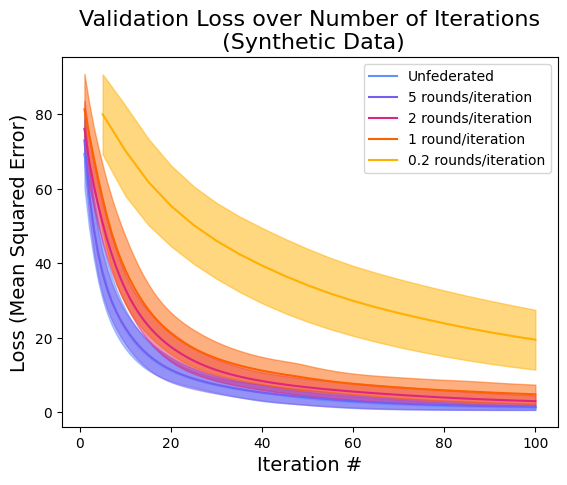

In [29]:
plt.plot(np.arange(len(unfed_loss)) + 1, unfed_loss, label="Unfederated", color="#648FFF")
plt.fill_between(np.arange(len(unfed_loss)) + 1, unfed_loss-unfed_error, unfed_loss+unfed_error, color="#648FFF", alpha=0.5)

plt.plot(np.arange(len(step_loss)) + 1, step_loss, label="5 rounds/iteration", color="#785EF0")
plt.fill_between(np.arange(len(step_loss)) + 1, step_loss-step_error, step_loss+step_error, color="#785EF0", alpha=0.5)

plt.plot(np.arange(len(fact_loss)) + 1, fact_loss, label="2 rounds/iteration", color="#DC267F")
plt.fill_between(np.arange(len(fact_loss)) + 1, fact_loss-fact_error, fact_loss+fact_error, color="#DC267F", alpha=0.5)

plt.plot(np.arange(len(full1_loss)) + 1, full1_loss, label="1 round/iteration", color="#FE6100")
plt.fill_between(np.arange(len(full1_loss)) + 1, full1_loss-full1_error, full1_loss+full1_error, color="#FE6100", alpha=0.5)

plt.plot((np.arange(len(full5_loss)) + 1)*5, full5_loss, label="0.2 rounds/iteration", color="#FFB000")
plt.fill_between((np.arange(len(full5_loss)) + 1)*5, full5_loss-full5_error, full5_loss+full5_error, color="#FFB000", alpha=0.5)
plt.legend()
plt.xlabel("Iteration #", fontsize=14)
plt.ylabel("Loss (Mean Squared Error)", fontsize=14)
plt.title("Validation Loss over Number of Iterations\n (Synthetic Data)", fontsize=16)
plt.show()

In [ ]:
# Performance testing
print("Stepwise federated algorithm training...")
hypers = {"max_iter": 100, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10}
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
cProfile.run("BCD_federated_stepwise(init_lsr_dot, client_datasets, val_dataset,\
              hypers, loss_fn, aggregator_fn, False)", sort='tottime')